`Problem Statement` - Given various features about a customer like Age, Income, Loan Amount, Loan Intent, Home Ownership etc.. , predict if in case the loan is given, will the customer default or not on the Loan payments.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

-  Here as per task it is required to find whether the customer will default the loan payment or not based on some given features.
-  Among all the given columns from historical data the feature `loan status` gives info like 0 - non defaulted and 1 - defaulted , which clearly is what needed to be predicted in case of new customers . So the column `loan status` becomes target feature .
-  All other columns can be used as input features to predict the target
-  Classification task
-  Accuracy score metric

In [ ]:
# Load and preprocess the dataset
dataset = pd.read_csv('/content/credit_risk_dataset.csv')
dataset.dropna(how='any', axis=0, inplace=True)
dataset.drop_duplicates(keep='first', inplace=True)
dataset['loan_status'] = dataset['loan_status'].astype('int')

In [ ]:
# One-hot encoding and feature extraction
categorical_cols = ['person_home_ownership', 'cb_person_default_on_file', 'loan_grade', 'loan_intent']
ct = ColumnTransformer(transformers=[('ohe', OneHotEncoder(handle_unknown="ignore", drop="first"), categorical_cols)],
                       remainder='passthrough')
X = ct.fit_transform(dataset.drop('loan_status', axis=1))
column_names = list(ct.get_feature_names_out())
X = pd.DataFrame(X, columns=column_names)
y = dataset['loan_status']

In [ ]:
# Train-Test Split and Feature Scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=24)
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


In [ ]:
# Create a function for model training and evaluation
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    test_score = accuracy_score(y_test, y_pred)
    train_score = accuracy_score(y_train , y_pred_train)
    return model, test_score , train_score

In [ ]:
# using randomized search cv instead of decision trees to avoid overfitting

dtc_model = DecisionTreeClassifier()

max_depth = np.linspace(3, 10, 6,dtype="int")
min_samples_split = [2, 5, 10, 15, 30, 35]
min_samples_leaf = [1, 2, 5, 10, 15,20,25]
criterion = ["gini","entropy"]
min_impurity_decrease = np.linspace(0.0001, 0.0005, 8)

param_grid = {"max_depth" : max_depth, "min_samples_split":min_samples_split,
             "min_samples_leaf":min_samples_leaf,"criterion":criterion,
             "min_impurity_decrease":min_impurity_decrease}

In [ ]:
# Model training and evaluation
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(n_estimators=8, criterion='entropy', max_depth=6),
    'KNN': KNeighborsClassifier(n_neighbors=9, p=2),
    'SVM': SVC(C=1, kernel='linear'),
    'RSV': RandomizedSearchCV(dtc_model, param_distributions = param_grid, n_iter = 500,
                         scoring = "accuracy", cv = 3, n_jobs = -1, verbose = 5)
}

In [ ]:
results_test = {}
results_train = {}
for model_name, model in models.items():
    trained_model, test_score ,train_score = train_and_evaluate_model(model, X_train, y_train, X_test, y_test)
    results_test[model_name] = (trained_model, test_score)
    results_train[model_name] = (trained_model , train_score)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


In [ ]:
# Real-time predictions
data1 = pd.DataFrame({'person_age': [30], 'person_income': [60000], 'person_home_ownership': ['MORTGAGE'],
                      'person_emp_length': [12], 'loan_intent': ['EDUCATION'], 'loan_grade': ['D'],
                      'loan_amnt': [50000], 'loan_int_rate': [15],
                      'loan_percent_income': [round((50000 / 60000), 2)], 'cb_person_default_on_file': ['N'],
                      'cb_person_cred_hist_length': [4]})
data2 = pd.DataFrame({'person_age': [24], 'person_income': [70000], 'person_home_ownership': ['RENT'],
                      'person_emp_length': [7], 'loan_intent': ['PERSONAL'], 'loan_grade': ['D'], 'loan_amnt': [50000],
                      'loan_int_rate': [17], 'loan_percent_income': [0.71], 'cb_person_default_on_file': ['N'],
                      'cb_person_cred_hist_length': [3]})

In [ ]:
data1 = ct.transform(data1)
data1 = sc.transform(data1)
data2 = ct.transform(data2)
data2 = sc.transform(data2)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [ ]:
predictions_data1 = {}
predictions_data2 = {}
for model_name, (model, _) in results_test.items():
    predictions_data1[model_name] = model.predict(data1)
    predictions_data2[model_name] = model.predict(data2)

In [ ]:
# Print results
for model_name, (_, test_score) in results_test.items():
    print(f'{model_name} Test Score: {test_score}  Train Score:{results_train[model_name][1]}')

print("\nReal Time Predictions for data1:")
print(predictions_data1)

print("\nReal Time Predictions for data2:")
print(predictions_data2)

Logistic Regression Test Score: 0.8666853774908785  Train Score:0.8679298245614036
Random Forest Test Score: 0.904153802975021  Train Score:0.9116725146198831
KNN Test Score: 0.8950322761717654  Train Score:0.9072280701754386
SVM Test Score: 0.8687903452147067  Train Score:0.8683508771929824
RSV Test Score: 0.9245018243053607  Train Score:0.9308538011695906

Real Time Predictions for data1:
{'Logistic Regression': array([1]), 'Random Forest': array([0]), 'KNN': array([0]), 'SVM': array([1]), 'RSV': array([0])}

Real Time Predictions for data2:
{'Logistic Regression': array([1]), 'Random Forest': array([1]), 'KNN': array([1]), 'SVM': array([1]), 'RSV': array([1])}


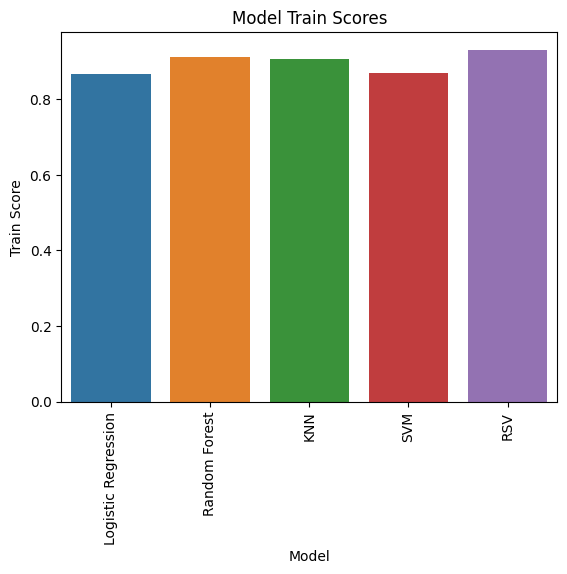

In [ ]:
# Plot train scores
sns.barplot(x=list(results_train.keys()), y=[score for _, score in results_train.values()])
plt.title('Model Train Scores')
plt.xlabel('Model')
plt.ylabel('Train Score')
plt.xticks(rotation=90)
plt.show()

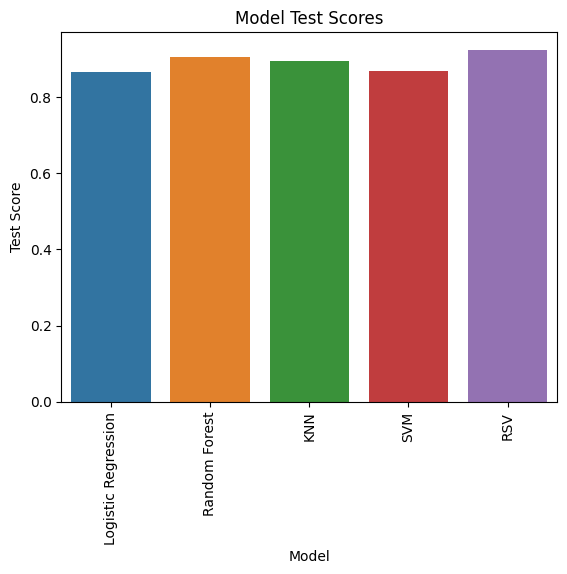

In [ ]:
# Plot test scores
sns.barplot(x=list(results_test.keys()), y=[score for _, score in results_test.values()])
plt.title('Model Test Scores')
plt.xlabel('Model')
plt.ylabel('Test Score')
plt.xticks(rotation=90)
plt.show()

### conclusion
- All models did perform well . When considered difference between test and train scores Support vector machine classfier model and logistic regression model seem to have best performance among all models .

- And , obviously , decision tree's arandomized search cv model is having higher performance